# Predicting Return on Investment (ROI) of Consumer Loans

**Andrew Nicholls** | Email: andrew.s.nicholls@gmail.com | [Github](https://github.com/Booleans)

If you are viewing this notebook on Github I recommend using the following nbviewer link instead to ensure proper formatting and working interactive charts.

[nbviewer link](https://nbviewer.jupyter.org/github/Booleans/Lending-Club-Loan-Analysis/blob/master/Loan_Analysis_Regression.ipynb)

## Summary

**Contents:**

1. [Problem Definition and Background Information](#1)
2. [Data Preparation: Wrangling, Cleaning, and Feature Extraction](#2)
3. [Exploratory Data Analysis](#3)
4. [Machine Learning Models](#4)
5. [Results and Findings](#4)
<a id='1'></a>

# 1. Introduction

### Problem Definition

LendingClub Corporation operates as an online marketplace that connects borrowers and investors in the United States. Its marketplace facilitates various types of loan products for consumers and small businesses, including unsecured personal loans, super prime consumer loans, unsecured education and patient finance loans, and unsecured small business loans. The company also offers investors an opportunity to invest in a range of loans based on term and credit characteristics. However, many loans issued through Lending Club end up being defaulted on by the borrower. The goal of this notebook is to examine the historical loan data available in order to generate a model to predict the return on investment that a new loan will generate.

### Files Provided

Lending Club provides CSV files of historical data for its loans. These files contain complete loan data for all loans issued through the time period stated, including the loan status (Current, Late, Fully Paid, etc.) and latest payment information. The files can be acquired on the [Lending Club Statistics Page](https://www.lendingclub.com/info/download-data.action). As of the creation of this project the latest data available from Lending Club was for Q1 2018.

For information on the definitions of fields contained within the historical data please see the [Lending Club Data Dictionary](https://github.com/Booleans/consumer-loan-survival-analysis/blob/master/data/LCDataDictionary.xlsx?raw=true).

The LoanStats3a file also contains information on loan applications that were declined and never issued. I have discarded those rows of data as they are not relevant to predicting loan defaults. I have also removed the last 2 rows of every spreadsheet, as they contained aggregate information on the number of loans in the file.

In [11]:
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

<a id='2'></a>


# 2. Data Preparation: Wrangling, Cleaning, and Feature Extraction

Certain columns may be immediately ignored and not loaded into the dataframe. Some columns provide information that was not available upon loan origination (e.g. interest received from loan payments, late fees collected). Other columns are dropped for containing information that is not relevant to whether a loan will default or not (e.g. borrower id number, url that the loan is listed at). Joint loan applications are relatively new at Lending Club therefore all columns related to joint applications and secondary applicants will be ignored.

For a complete list of columns ignored please see the [columns.py](Column_Info.py) file.

### Create DataFrame of Relevant Loans:

We only want loans that have either been fully paid or charged off. We cannot calculate the final return on investment of loans that are still current. 

In [12]:
%run src/columns.py

loan_data = []
csv_file_names = ('LoanStats3a_securev1', 'LoanStats3b_securev1', 'LoanStats3c_securev1', 'LoanStats3d_securev1',
                  'LoanStats_securev1_2016Q1', 'LoanStats_securev1_2016Q2', 'LoanStats_securev1_2016Q3',
                  'LoanStats_securev1_2016Q4', 'LoanStats_securev1_2017Q1', 'LoanStats_securev1_2017Q2', 
                  'LoanStats_securev1_2017Q3', 'LoanStats_securev1_2017Q4', 'LoanStats_securev1_2018Q1')

for file in csv_file_names:    
    data = pd.read_csv('data/' + file + '.csv', header = 1, low_memory=False, na_values='n/a', usecols=columns_to_use, nrows=1000) 
    loan_data.append(data)
    
loans = pd.concat(loan_data)

# We only want loans that have completed. Loan status should be either Fully Paid or Charged Off.
loans = loans[(loans['loan_status'] == 'Charged Off') | (loans['loan_status'] == 'Fully Paid')]
loans.drop('loan_status', axis=1, inplace=True)

# As stated previously, we are ignoring loans with a joint applicant.
loans = loans[loans['application_type'] == "INDIVIDUAL"]
loans.drop(labels=['application_type'], axis=1, inplace=True)

print(str(loans.shape[0]) + ' loans with ' + str(loans.shape[1]) + ' features.')

3415 loans with 86 features.


In [13]:
loans.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,Dec-11,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
1,2500,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2,2400,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-11,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
3,10000,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-11,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
4,3000,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,Dec-11,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN


### Cleaning the Data

The dataframe has been created from the loan data but not all columns are being read in as the correct type. For example, interest rate columns contain a '%' so those fields were read in as a string instead of a float. We need to write functions to clean clean up issues such as the above.

In [14]:
# Columns that end with % were read in as strings instead of floats. We need to remove the % and change data types.
rate_cols = ['int_rate', 'revol_util']

for col in rate_cols:
    loans[col] = loans[col].str.rstrip('%').astype('float64')

# issue_d column can be in two formats. This function will handle the conversion of both formats.
def convert_date(col_date):
    if col_date[0].isdigit():
        # Need to pad the date string with a 0 if it's too short. 
        col_date = col_date.rjust(6, '0')
        return pd.to_datetime(col_date, format = '%y-%b')
    else:
        try:
            return pd.to_datetime(col_date, format = '%b-%y')
        except:
            return pd.to_datetime(col_date, format = '%b-%Y')
    
loans['issue_d'] = loans['issue_d'].map(convert_date)

# Term should be either '36' or '60'.
loans['term'] = [30 if row.strip() == '36 months' else 60 for row in loans['term']]

loans['emp_length'] = [0 if row == '< 1 year' else row for row in loans['emp_length']]
loans['emp_length'] = loans['emp_length'].str.extract('(\d+)', expand=True).astype(float)

### Visualizing Missing Data

It is likely that significant amount of data will be missing from our dataframe. This is due to the fact that Lending Club no longer provides certain details for newer loans. For example, borrowers used to be able to write text to give their loans a title and description. Borrowers are no longer allowed to do so. The zip code field used to be provided but now it has been obscured by Lending Club so that investors do not discriminate against borrowers in poor or minority neighborhoods. Certain fields, such as information that only applies to loans being made by two applicants together, are rarely used. A heatmap will give a visual representation of missing data, where missing data is green.  

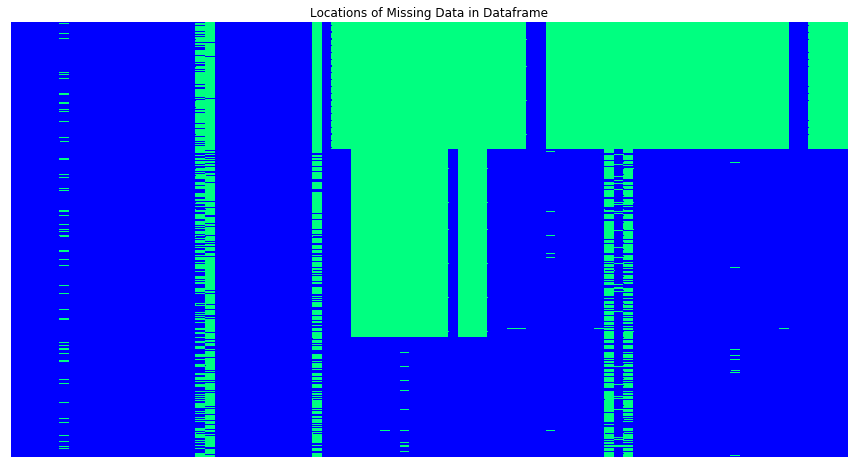

In [15]:
plt.figure(figsize=(15, 8))
plt.title("Locations of Missing Data in Dataframe")
sns.heatmap(loans.isnull(), yticklabels=False, xticklabels=False, cbar=False, cmap='winter');

Let's take a look at which columns specifically are missing data and what percent or rows are missing for each column.

In [16]:
def getPctMissing(series):
    num = series.isnull().sum()
    total = series.count()
    return 100*(num/total)

df = pd.DataFrame(round(loans.isnull().sum()/len(loans) * 100,2))
df = df.rename(columns={0: 'PctMissing'})
df.sort_values(by='PctMissing', ascending=False, inplace=True)

df[df['PctMissing'] > 0]

missing_cols = []
for col in df[df['PctMissing'] > 0].index:
    missing_cols.append(col)

In [17]:
def get_cols_missing_data(df):
    cols = []
    df_temp = pd.DataFrame(round(df.isnull().sum()/len(df) * 100,2))
    df_temp = df_temp.rename(columns={0: 'pct_missing'})

    for col in df_temp[df_temp['pct_missing'] > 0].index:
        cols.append(col)

    return cols

def create_missing_data_boolean_columns(df):
    cols_missing_data = get_cols_missing_data(df)
    for col in cols_missing_data:
        df[col+"_missing"] = df[col].isnull().astype('uint8')

    return df

In [18]:
def fill_nas(df, value=-99):
    for col in df.columns:
        df[col].fillna(value, inplace=True)
        
    return df

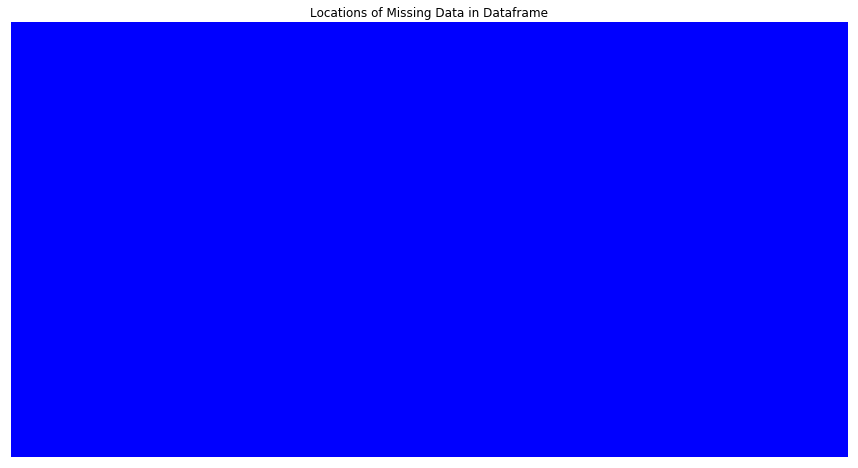

In [20]:
loans = fill_nas(loans)
plt.figure(figsize=(15, 8))
plt.title("Locations of Missing Data in Dataframe")
sns.heatmap(loans.isnull(), yticklabels=False, xticklabels=False, cbar=False, cmap='winter');

Filling in Missing Data

Feature Engineering

In [ ]:
loans['has_recent_delinq'] = loans['mths_since_last_delinq'].notnull().astype(int)
loans['has_recent_revol_delinq'] = loans['mths_since_recent_revol_delinq'].notnull().astype(int)
loans['year'] = loans.issue_d.dt.year
loans['month'] = loans.issue_d.dt.month